Import Necessary Libraries : 
---

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

c:\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load The descriptions file into memory :
---

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "data/Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


Parse Descriptions :
---
Preprocess the Descriptions by parsing the file and returning the mapped dictionary with keys as image name and a list of descriptions as the Value.

In [3]:
def load_descriptions(doc):
    mapping = dict()   
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
descriptions['3323514651_3efdbd63ed']

['A basketball player in black jumps , while another in white attempts to block .',
 'one boy wearing a black jersey holding a basketball while another is behind him trying to get the ball',
 'Two basketball players fighting over the ball .',
 'Two male basketball players are fighting over a basketball .',
 'Two young men play basketball while crowd looks on']

Prep Descriptions :
---
prepare translation table for removing punctuation, numbers etc. 

In [5]:
def clean_descriptions(descriptions):
    #construct a mapping table to map string.punctuations to null character
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [6]:
descriptions['3323514651_3efdbd63ed']

['basketball player in black jumps while another in white attempts to block',
 'one boy wearing black jersey holding basketball while another is behind him trying to get the ball',
 'two basketball players fighting over the ball',
 'two male basketball players are fighting over basketball',
 'two young men play basketball while crowd looks on']

Make Vocab :
---
Take unique words occuring in the 8k examples and make a vocab from them. 
Set only accepts words once. 

In [7]:
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


Save the Descriptions Vocab on Disk :


In [8]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'desc.txt')

### Load the Trainset Identifiers :


In [9]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'data/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


### Create List of All Image Names in Dataset : 

In [10]:
images = 'data/Flicker8k_Dataset/' #path to all images
img = glob.glob(images + '*.jpg')

In [11]:
img[0:5]

['data/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'data/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'data/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'data/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'data/Flicker8k_Dataset\\1007129816_e794419615.jpg']

### Create a list of all the training images with their full path names :

In [12]:
# Below file contains the names of images to be used in train data
train_images_file = 'data/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [13]:
train_img[0:5]

['data/Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 'data/Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 'data/Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 'data/Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 'data/Flicker8k_Dataset\\1007129816_e794419615.jpg']

In [14]:
### Create a list of all the test images with their full path names :

In [15]:
# Below file contains the names of images to be used in test data
test_images_file = 'data/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [16]:
test_img[0:5]

['data/Flicker8k_Dataset\\1056338697_4f7d7ce270.jpg',
 'data/Flicker8k_Dataset\\106490881_5a2dd9b7bd.jpg',
 'data/Flicker8k_Dataset\\1082379191_ec1e53f996.jpg',
 'data/Flicker8k_Dataset\\1084040636_97d9633581.jpg',
 'data/Flicker8k_Dataset\\1096395242_fc69f0ae5a.jpg']

### Load descriptions for train set :

In [17]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('desc.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [18]:
list(train_descriptions.keys())[:5]

['2353119813_685bace18e',
 '2666078276_f7b3056997',
 '411011549_1298d2b4d2',
 '415657941_454d370721',
 '256292144_b53aadae27']

In [19]:
train_descriptions['2196050115_e236d91f52']

['startseq boy is aiming bow and arrow at target endseq',
 'startseq boy is firing gun at bullseye attached to hay barrel endseq',
 'startseq boy taking aim at target on bale of hay with his bow and arrow endseq',
 'startseq young archer aims his bow at haystack target endseq',
 'startseq boy wearing jeans aiming bow and arrow toward target on hay bale endseq']

### Define Function to Preprocess the Images

Requirements for Inception V3 :
1. main size = 299x299
2. numpy array
3. extra dimension added
4. preprocess_input() from Inception Applied

In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

### Load Inception V3 and Create Model Instance


In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [22]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

### Function to Encode an Image into a Vector (2048,)

In [23]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

Now Encode and Henceforth Save : 

In [43]:
start = time()
encoding_train = {} # maps image name to image data
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 546.9033396244049


In [44]:
encoding_train['2196050115_e236d91f52.jpg'].shape

(2048,)

In [45]:
import pickle
# Save the bottleneck train features to disk
with open("data/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) # save the data in encoding_train into encoding_pickle.

Do the same for Test Images :

In [46]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 102.80644416809082


In [57]:
# Save the bottleneck test features to disk
with open("data/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

### Load the data we just saved : 

In [24]:
train_features = load(open("data/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


### Create a list of all the training captions :

In [25]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [26]:
all_train_captions[:4]

['startseq dog is jumping playing with ball that has broken endseq',
 'startseq dog jumps for yellow and black ball endseq',
 'startseq dog jumps to catch ball in large field endseq',
 'startseq dog playing in park endseq']

Consider only words which occur at least 10 times in the corpus and add to vocabulary:

In [27]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1 #counting number of times word w has occurred 

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [28]:
vocab[0:5]

['lab', 'store', 'sings', 'type', 'to']

In [29]:
list(word_counts.items())[:4]

[('fro', 1), ('slipper', 4), ('swipes', 1), ('fortune', 1)]

## Form mapping from index to word and word to index :

In [30]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

### Convert a dictionary of clean descriptions to a list of descriptions :

This will come in handy later when we preprocess data for the embedding-LSTM(Decoder) part.

In [32]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### Define Generator for use in training : 
- Takes as input the descriptions dict, photos data(2048), word2index data, etc. 
- Yields as output a list of 3 lists, with the photo, input sequence and output sequence
- number of photos depends on num_photos_per_batch

In [33]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Load GloVe Vectors : 
- load glove and read
- find number of word vectors

In [34]:
# Load Glove vectors
glove_dir = 'data/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Embed the descriptions using the vectors in glove :

In [35]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(1652, 200)

### Define Model :

In [36]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [38]:
model.layers[2]

In [39]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [42]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [47]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 269s 134ms/step - loss: 3.7890
Epoch 1/1
2000/2000 [==============================] - 269s 134ms/step - loss: 3.3486
Epoch 1/1
2000/2000 [==============================] - 279s 140ms/step - loss: 3.1638
Epoch 1/1
2000/2000 [==============================] - 277s 139ms/step - loss: 3.0397
Epoch 1/1
2000/2000 [==============================] - 275s 137ms/step - loss: 2.9513
Epoch 1/1
2000/2000 [==============================] - 281s 141ms/step - loss: 2.8819
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.8265
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 2.7814
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.7410
Epoch 1/1
2000/2000 [==============================] - 278s 139ms/step - loss: 2.7086


In [48]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 274s 137ms/step - loss: 2.6805
Epoch 1/1
2000/2000 [==============================] - 279s 139ms/step - loss: 2.6594
Epoch 1/1
2000/2000 [==============================] - 277s 138ms/step - loss: 2.6343
Epoch 1/1
2000/2000 [==============================] - 272s 136ms/step - loss: 2.6176
Epoch 1/1
2000/2000 [==============================] - 273s 136ms/step - loss: 2.5976
Epoch 1/1
2000/2000 [==============================] - 274s 137ms/step - loss: 2.5824
Epoch 1/1
2000/2000 [==============================] - 280s 140ms/step - loss: 2.5708
Epoch 1/1
2000/2000 [==============================] - 272s 136ms/step - loss: 2.5558
Epoch 1/1
2000/2000 [==============================] - 276s 138ms/step - loss: 2.5432
Epoch 1/1
2000/2000 [==============================] - 284s 142ms/step - loss: 2.5315


In [49]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [50]:

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 159s 159ms/step - loss: 2.4794s -
Epoch 1/1
1000/1000 [==============================] - 169s 169ms/step - loss: 2.4583
Epoch 1/1
1000/1000 [==============================] - 171s 171ms/step - loss: 2.4525
Epoch 1/1
1000/1000 [==============================] - 173s 173ms/step - loss: 2.4394
Epoch 1/1
1000/1000 [==============================] - 173s 173ms/step - loss: 2.4293
Epoch 1/1
1000/1000 [==============================] - 170s 170ms/step - loss: 2.4182
Epoch 1/1
1000/1000 [==============================] - 172s 172ms/step - loss: 2.4086
Epoch 1/1
1000/1000 [==============================] - 178s 178ms/step - loss: 2.4012
Epoch 1/1
1000/1000 [==============================] - 169s 169ms/step - loss: 2.3931
Epoch 1/1
1000/1000 [==============================] - 167s 167ms/step - loss: 2.3844


In [51]:
model.save_weights('./model_weights/model_30.h5')

In [52]:
open('model.json', 'w').write(model.to_json())
model.save_weights('weights.h5')

In [53]:
model.load_weights('./model_weights/model_30.h5')

In [54]:
images = 'data/Flicker8k_Dataset/'
with open("data/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [55]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [56]:
z=0

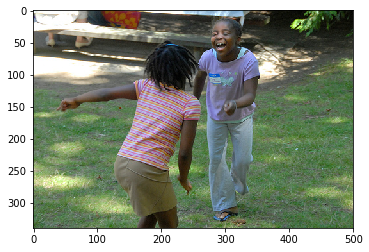

Greedy: boy in red shirt and blue jeans is playing in the grass


In [59]:

z +=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [60]:
from keras.models import model_from_json

model2 = model_from_json(open('model.json').read())
model2.load_weights('weights.h5')


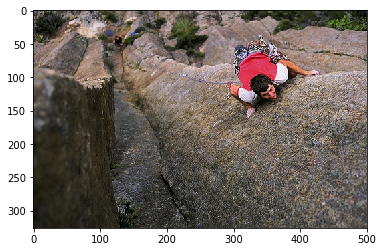

Greedy: man in blue hat and khaki pants is standing on rock overlooking the mountains


In [63]:
def greedySearch2(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model2.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


z +=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch2(image))